In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [2]:
stock_data = pd.read_excel("data/NLP_TA_data.xlsx").set_index('Date')
stock_data = stock_data.iloc[:, :12]

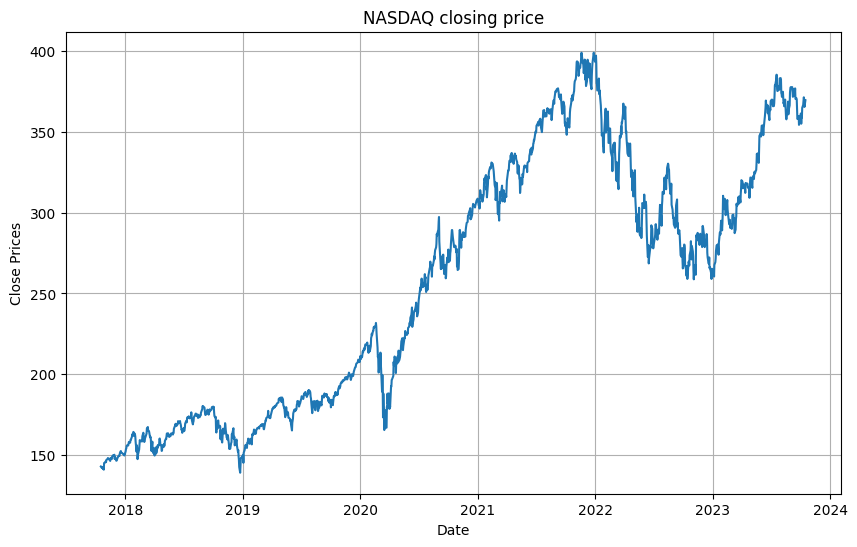

In [3]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(stock_data['Close'])
plt.title('NASDAQ closing price')
plt.show()

<Axes: ylabel='Density'>

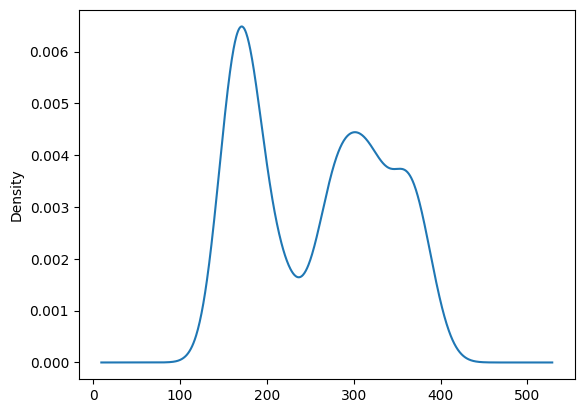

In [4]:
df_close = stock_data['Close']
df_close.plot(kind='kde')

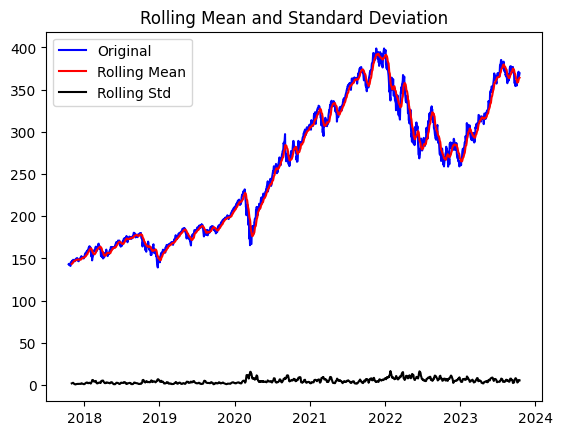

Results of dickey fuller test
Test Statistics                  -0.949426
p-value                           0.771261
No. of lags used                 11.000000
Number of observations used    1497.000000
critical value (1%)              -3.434726
critical value (5%)              -2.863473
critical value (10%)             -2.567799
dtype: float64


In [5]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
test_stationarity(df_close)

<Figure size 640x480 with 0 Axes>

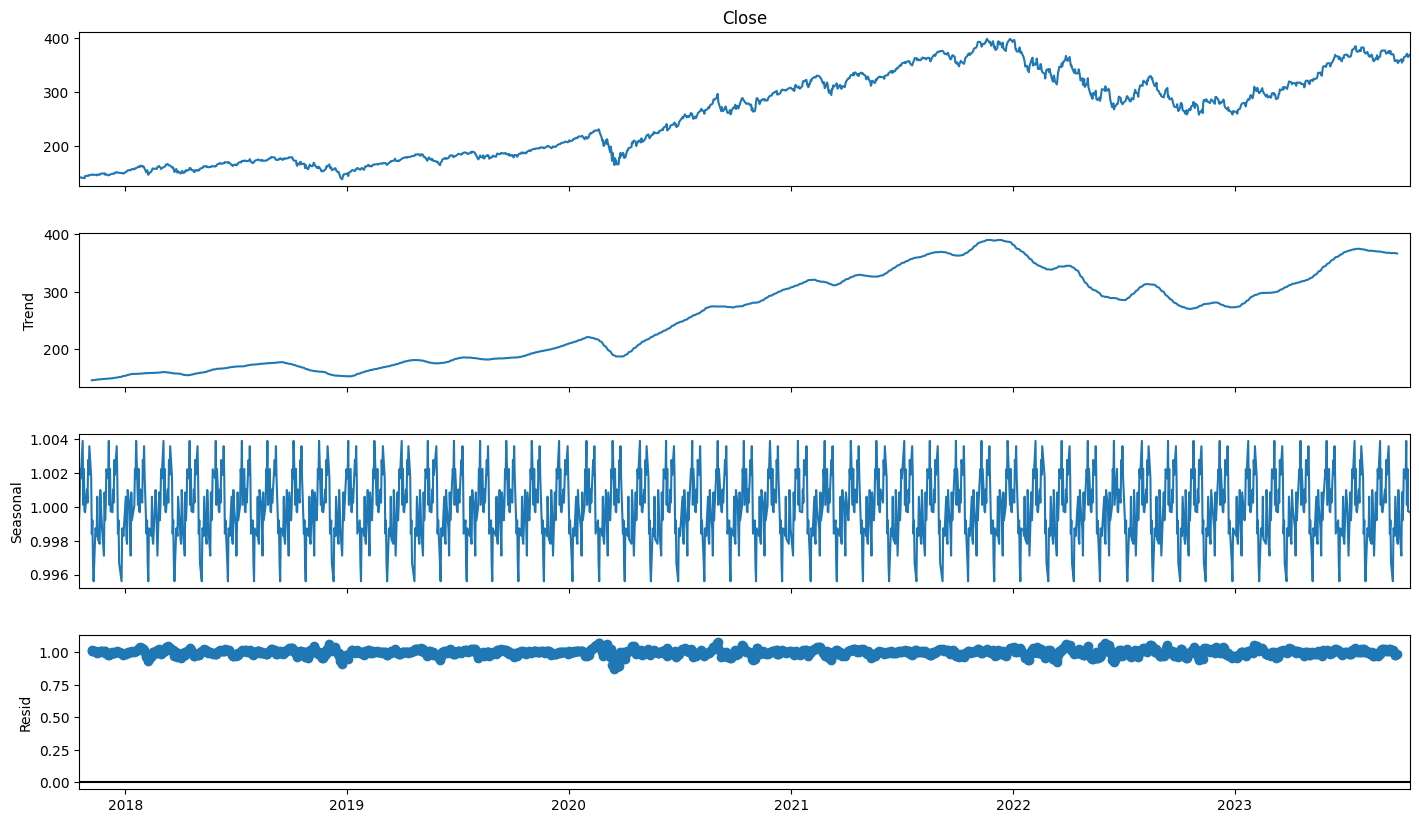

In [6]:
result = seasonal_decompose(df_close, model='multiplicative', period = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


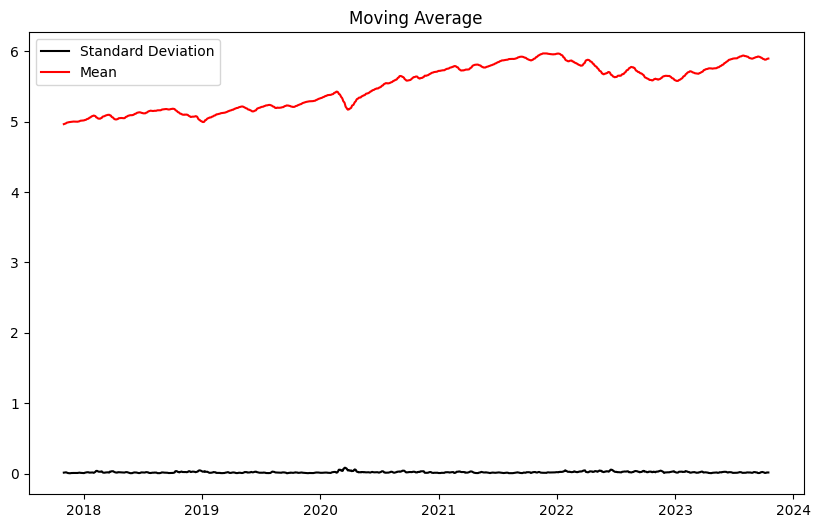

In [7]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

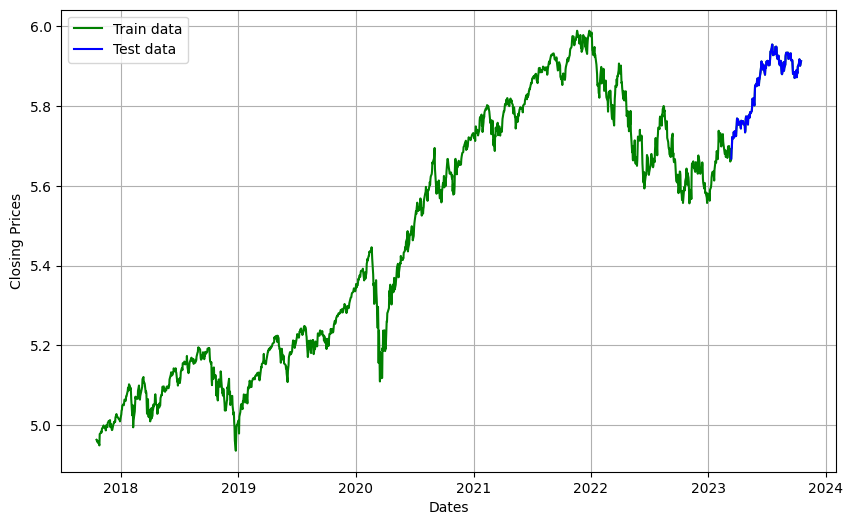

In [8]:
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-7311.832, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-7340.087, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-7338.158, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-7312.462, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-7338.834, Time=0.37 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-7338.754, Time=0.38 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-7336.834, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-7340.227, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-7339.066, Time=0.18 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-7338.959, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-7338.252, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-7337.060, Time=0.25 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 1.986 seconds
                               SARIMAX Results                              

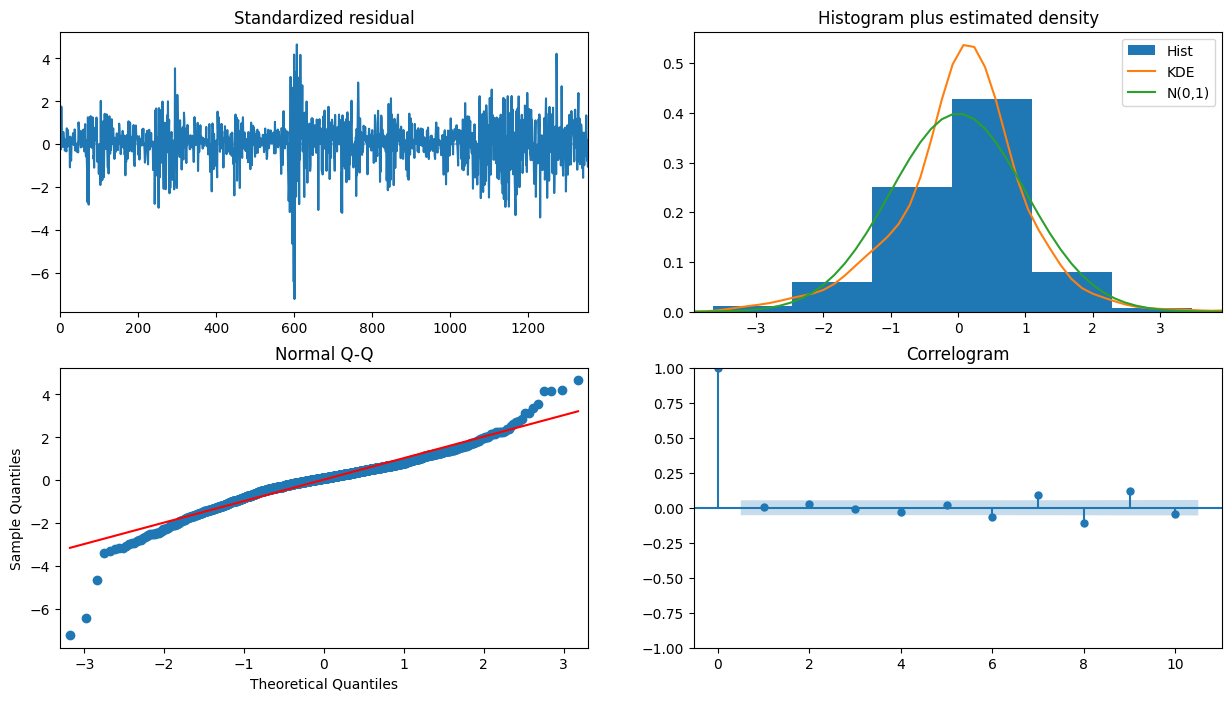

In [9]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [10]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(train_data, order=(1,1,2))  
fitted = model.fit()  
print(fitted.summary())



c:\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1355
Model:                 ARIMA(1, 1, 2)   Log Likelihood                3671.301
Date:                Mon, 27 Nov 2023   AIC                          -7334.602
Time:                        21:37:19   BIC                          -7313.759
Sample:                             0   HQIC                         -7326.797
                               - 1355                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5666      0.234     -2.425      0.015      -1.025      -0.109
ma.L1          0.4235      0.229      1.846      0.065      -0.026       0.873
ma.L2         -0.0371      0.044     -0.843      0.3

In [11]:
fitted.forecast(151, alpha=0.05)

c:\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


1355    5.661975
1356    5.661769
1357    5.661886
1358    5.661820
1359    5.661857
          ...   
1501    5.661843
1502    5.661843
1503    5.661843
1504    5.661843
1505    5.661843
Name: predicted_mean, Length: 151, dtype: float64

c:\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


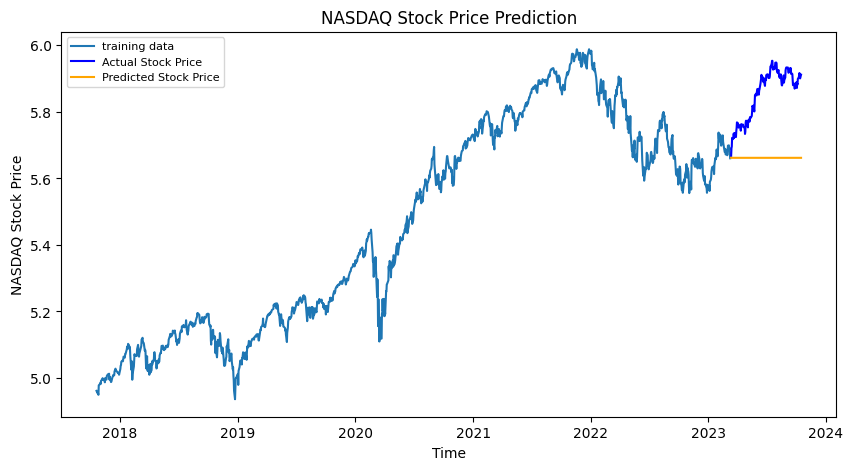

In [12]:
fc= fitted.forecast(151)  # 95% conf
# Make as pandas series
fc_series = pd.Series(np.atleast_1d(fc), index=test_data.index)
# lower_series = pd.Series(conf[:, 0], index=test_data.index)
# upper_series = pd.Series(conf[:, 1], index=test_data.index)
# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training data')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
# plt.fill_between(lower_series.index, lower_series, upper_series, 
#                  color='k', alpha=.10)
plt.title('NASDAQ Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('NASDAQ Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [13]:
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

MSE: 0.04227182505851788
MAE: 0.19153468668603615
RMSE: 0.20560113097577523
MAPE: nan
